# DRP Detector Old Model
## Preface
The goal of the project is to create a Machine Learning algorithm that can compare eye images and categorize if there are diseases present.

In this document I'll be attempting to create a machine learning model that can accurately detect what category of DRP is present in the image.

Most of these use Fundus photography that are taken with a machine that is available in places other then hospitals. 
https://en.wikipedia.org/wiki/Fundus_photography

## Data set
The stakeholder and I found multiple data sets that can be used for this purpose, but decided to use the following dataset:

Dataset of eyes with and without Diabetische retinopathie.
https://www.kaggle.com/donkeys/retinopathy-train-2015?select=trainLabels.csv


### Research questions
For this I'll need be researching the following technical requirements:
- How do you create a Machine Learning sorting model using images?
- How do you convert images into a data format that can be read by python/a machine learning algorithm?
- How do you ensure the quality of the model and evaluate the performance?



## On the  data set 

The dataset provides a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

- 0.  No DR
- 1.  Mild
- 2.  Moderate
- 3.  Severe
- 4.  Proliferative DR

The stakeholder has requested that we extend the dataset by adding the following category:

- 5.  Other disease

This is a requirement for allowing the model to be usefull to the stakeholder.

## Importing libraries
Here I import a number of libraries required for creating the machine learning model:
- os/shutil: finding/loading/sorting the images
- matplotlib: Displaying the loaded images in a graph.
- pandas/numpy: math libraries with various datatypes and advanced functions used in calculations. also requirements for SKlearn to work.
- skimage: loading a list of images into an array
- sklearn: creating the machine learning model
- joblib: saving the model to a file for later use. prevents the retraining of models.

In [2]:
# File moving imports
import os
import shutil

# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import datasets, classifiers and performance metrics
import skimage.io as io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

#save model
from joblib import dump, load


## Labels
Load the labels containing the DRP category of the images used while training the model.

The algorithm uses these labels to train the model.

In [3]:
labels = pd.read_csv("C:/Users/mauri/Documents/GitHub/EyeDiseaseDetection/Data/DrpTest/trainLabels.csv")

In [4]:
labels_reset = labels.set_index('image')
# labels_reset[['level']]

label_list =(labels_reset[['level']].values.flatten().tolist())

In [5]:
label_list = np.asarray(label_list)
label_list

array([0, 0, 0, ..., 0, 0, 1])

Convert the numbers into readable words. This is make it easier for the stakeholder to understand of the results.

In [6]:
label_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
label_names[label_list[1]]

'No DR'

Since we're using 800 images for this model, we need to cut all labels after 800 to keep it the same size as the image list. 

If the sizes differ the model will not accept the input

In [7]:
label_list = label_list[0:800]
label_list[0]

0

## Model
### Loading the images
First, create 2 functions that load the images using a load function. This load funtion resizes all images to the same resolution and the 2nd one also greyscales them to remove a third demension from the array.

In [18]:
def transformImage(f, img_num=None):
        img = io.imread(f)
        im_res = resize(img,(597, 896))
        return im_res

def transformImageFlat(f, img_num=None):
        img = io.imread(f)
        # im_res = resize(img,(597, 896))
        ## Turn images grey
        img_gray = rgb2gray(img)        
        im_res = resize(img_gray,(597, 896))
        im_res = np.reshape(im_res, 534912)

        return im_res

In [19]:
if __name__ == "__main__":
    img_collections = io.ImageCollection('Data/testSet/*.png',load_func=transformImage)
    img_collectionsFlat = io.ImageCollection('Data/testSet/*.png',load_func=transformImageFlat)

In [20]:
i = 0
print(img_collections[i].shape)
print(img_collectionsFlat[i].shape)

(597, 896, 3)
(534912,)


Here is a sample of the loaded image array:

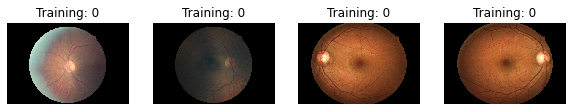

In [21]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, img_collections, label_list):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

### Creating the model
Here we load  the image list into a SCV model. The data set is divided into a 70% training set and  a 30% test set. 

This ensures that the model is trained on diffrent images then it is tested on.

After training is done i used "predict" to make the model try to predict the correct category on the test set.

In [22]:
# flatten the images
n_samples = len(img_collections)
data = img_collectionsFlat

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, label_list, test_size=0.3, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

Here you can see 5 sample images that were predicted on.

Pred stand for what the model thinks is the correct category, Real is what is written in the label list.

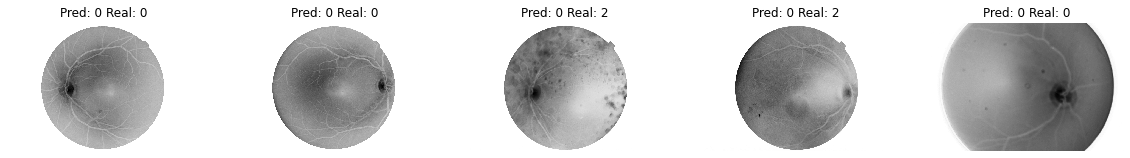

In [23]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))
for ax, image, prediction, realCat in zip(axes, X_test, predicted, y_test):
    ax.set_axis_off()
    image = image.reshape(597, 896)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Pred: {prediction} Real: {realCat}")

### Evaluation
Here we run an evaluation matrix showing various performance statistics.

In [24]:
print(
    f"CLassification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

CLassification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       187
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        37
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2

    accuracy                           0.78       240
   macro avg       0.16      0.20      0.18       240
weighted avg       0.61      0.78      0.68       240




c:\Users\mauri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Biased dataset issue
The models performance seen above shows that there is a disproportinate amount of category 0 compared to the others. Here I run some calculations with pandas to find the cause.

In [22]:
temp = labels_reset.apply(pd.value_counts)
temp['ImageCount'] = temp['level']
temp['Percentage'] = temp['level']
temp = temp.drop(labels='level', axis="columns")
for index, column in enumerate(temp['ImageCount']):
    temp.at[index, 'Percentage'] = ((temp.at[index, 'Percentage']) / 35126 * 100)
temp.at[5, 'Percentage'] = 100
temp.at[5, 'ImageCount'] = 35126
temp

,ImageCount,Percentage
0,25810.0,73.0
2,5292.0,15.0
1,2443.0,6.0
3,873.0,2.0
4,708.0,2.0
5,35126.0,100.0


It seems that 73% of the data is category 0. This leads to a biased model that makes classification models predict everything as a single category.

## Conclusion
The models performance is ot low to improve trough conventional means. The issue likely lies in the biased dataset problem discussed above.

In order to fix this issue, I'll be attempting to sort the the data into a dataset where all categories are relatively similarly present.

Creating even partitions would lead to a maximum of 708*5=3540 images. This is still enough to train the model on.

Code requirements:
- Create a list of labels that includes an even amount of all categories.
- Create a way for the algorithm to only load the images in the list.